In [1]:
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import copy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
STOP_WORDS_EN = set(stopwords.words('english'))
STEMMER = SnowballStemmer('romanian')
MAX_LEN = 32

WORD_TO_INDEX = {}
WORD_TO_INDEX["<mask>"] = 0 
WORD_TO_INDEX["<pad>"] = 1
WORD_TO_INDEX["<unk>"] = 2

def get_tokens(caption):
    caption = caption.lower()
    
    caption = re.sub(r'[^\w\s]', ' ', caption)
    caption = re.sub(r'\s+', ' ', caption)
    caption = word_tokenize(caption)
    
    tokens = []
    for word in caption:
        if word not in STOP_WORDS_EN:
            stemmed_word = STEMMER.stem(word)
            tokens.append(stemmed_word)
    
    return tokens

def build_vocab(tokenized_captions):
    global WORD_TO_INDEX
    vocab = Counter(word for sent in tokenized_captions for word in sent)
    for id, (word, _) in enumerate(vocab.items()):
        if word not in WORD_TO_INDEX:
            WORD_TO_INDEX[word] = id+3

class CaptionsDataset(Dataset):
    def __init__(self, root, split):
        global WORD_TO_INDEX
        csv_file = pd.read_csv(os.path.join(root, f"{split}.csv"))
        self.split = split

        captions = csv_file["caption"].to_numpy()
        
        tokenized_captions = []
        for caption in captions:
            tokenized_captions.append(get_tokens(caption))

        build_vocab(tokenized_captions)
        
        encoded_captions = []
        masked_captions = []
        self.labels = []
        for tokenized_caption in tokenized_captions:
            encoded_caption = []
            for token in tokenized_caption:
                if token in WORD_TO_INDEX:
                    encoded_caption.append(WORD_TO_INDEX[token])
                else:
                    encoded_caption.append(WORD_TO_INDEX["<unk>"])

            encoded_captions.append(encoded_caption)

            mask_idx = np.random.randint(len(encoded_caption))
            masked_caption = copy.deepcopy(encoded_caption)
            masked_caption[mask_idx] = WORD_TO_INDEX["<mask>"]

            self.labels.append(encoded_caption[mask_idx])
            masked_captions.append(masked_caption)
        
        encoded_captions_padded = []
        masked_captions_padded = []
        for encoded_caption, masked_caption in zip(encoded_captions, masked_captions):
            num_pads = MAX_LEN - len(encoded_caption)
            encoded_captions_padded.append(encoded_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)
            masked_captions_padded.append(masked_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)

        self.data = [encoded_captions_padded, masked_captions_padded]

    def __len__(self):
        return len(self.data[0])
        
    def __getitem__(self, idx):
        sample = self.data[0][idx]
        sample = torch.tensor(sample).int()

        masked_sample = self.data[1][idx]
        masked_sample = torch.tensor(masked_sample).int()

        label = self.labels[idx]
        
        return masked_sample, label

In [3]:
class LanguageModel(nn.Module):
    def __init__(self, params):
        super(LanguageModel, self).__init__()
        if len(params) > 0:
            vocab_size = params["vocab_size"]
            embed_dim = params["embed_dim"]
            hidden_dim = params["hidden_dim"]
            num_layers = params["num_layers"]
            
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden_state, _) = self.lstm(x)
        out = self.linear(hidden_state[-1])
        return out

In [4]:
batch_size = 64
lr = 1e-3
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

root = "/kaggle/input/image-sentence-pair-matching"

train_dataset = CaptionsDataset(root, "train")
val_dataset = CaptionsDataset(root, "val")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

params = {
    "vocab_size": len(WORD_TO_INDEX), 
    "embed_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1
}

In [7]:
def train_step(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    for txt_inputs, labels in tqdm(train_loader):
        txt_inputs, labels = txt_inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(txt_inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(predictions == labels).item()
        total_preds += labels.shape[0]

    train_step_loss = total_loss / len(train_loader)
    train_step_acc = correct_preds / total_preds

    return train_step_loss, train_step_acc

def val_step(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    with torch.no_grad():
        for txt_inputs, labels in tqdm(val_loader):
            txt_inputs, labels = txt_inputs.to(device), labels.to(device)

            outputs = model(txt_inputs)
            loss = loss_fn(outputs, labels)
    
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(predictions == labels).item()
            total_preds += labels.shape[0]

    val_step_loss = total_loss / len(val_loader)
    val_step_acc = correct_preds / total_preds

    return val_step_loss, val_step_acc

def train():
    model = LanguageModel(params).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0.0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_step_loss, train_step_acc = train_step(model, train_dataloader, optimizer, loss_fn)
        print(f"train_step_loss: {train_step_loss} | train_step_acc = {train_step_acc}")
        
        val_step_loss, val_step_acc = val_step(model, val_dataloader, loss_fn)
        print(f"val_step_loss: {val_step_loss} | val_step_acc = {val_step_acc}")

        train_losses.append(train_step_loss)
        train_accs.append(train_step_acc)
        val_losses.append(val_step_loss)
        val_accs.append(val_step_acc)

        if val_step_acc > best_acc:
            best_acc = val_step_acc
            torch.save(model.state_dict(), "language_model.pt")

    plt.plot(range(epochs), train_losses)
    plt.title("Train loss")
    plt.savefig("train_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), train_accs)
    plt.title("Train acc")
    plt.savefig("train_acc.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_losses)
    plt.title("Val loss")
    plt.savefig("val_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_accs)
    plt.title("Val acc")
    plt.savefig("val_acc.jpg")
    plt.plot()

epoch: 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.913601240534692 | train_step_acc = 0.0135


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.685855865478516 | val_step_acc = 0.018666666666666668
epoch: 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.517429737528419 | train_step_acc = 0.0173


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.704361743115364 | val_step_acc = 0.018666666666666668
epoch: 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.492786398359165 | train_step_acc = 0.0175


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.737327961211509 | val_step_acc = 0.018666666666666668
epoch: 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.481505184416559 | train_step_acc = 0.0177


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.750126453156167 | val_step_acc = 0.018666666666666668
epoch: 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.476586329709193 | train_step_acc = 0.0178


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.766704670926358 | val_step_acc = 0.018666666666666668
epoch: 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.470346022563375 | train_step_acc = 0.0166


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.797672352892287 | val_step_acc = 0.018666666666666668
epoch: 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.469464848755272 | train_step_acc = 0.0169


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.803112141629483 | val_step_acc = 0.018666666666666668
epoch: 8


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.465419635651218 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.82764440901736 | val_step_acc = 0.018666666666666668
epoch: 9


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.464199539962088 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.818905586891986 | val_step_acc = 0.018666666666666668
epoch: 10


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.460581818963312 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.824233481224547 | val_step_acc = 0.018666666666666668
epoch: 11


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.463075036455871 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.840951016608705 | val_step_acc = 0.018666666666666668
epoch: 12


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.45480850244024 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.856709713631488 | val_step_acc = 0.018666666666666668
epoch: 13


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.456356977960866 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.881255626678467 | val_step_acc = 0.018666666666666668
epoch: 14


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.45450421655254 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.885533434279422 | val_step_acc = 0.018666666666666668
epoch: 15


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.454684867980374 | train_step_acc = 0.0177


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.8785215945954015 | val_step_acc = 0.018666666666666668
epoch: 16


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.441085132064333 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.843942408866071 | val_step_acc = 0.018666666666666668
epoch: 17


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.376806037441181 | train_step_acc = 0.0224


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.746490569824868 | val_step_acc = 0.022333333333333334
epoch: 18


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.264202473269906 | train_step_acc = 0.0248


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.705851544725134 | val_step_acc = 0.023333333333333334
epoch: 19


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.156022794687065 | train_step_acc = 0.0273


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.663455597897793 | val_step_acc = 0.025333333333333333
epoch: 20


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.066884183579949 | train_step_acc = 0.0277


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.622340232767957 | val_step_acc = 0.030333333333333334
epoch: 21


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.880061425980489 | train_step_acc = 0.0392


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.503713344005829 | val_step_acc = 0.042666666666666665
epoch: 22


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.690346878804978 | train_step_acc = 0.0525


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.475174822705857 | val_step_acc = 0.044333333333333336
epoch: 23


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.47919698885292 | train_step_acc = 0.0591


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.436252492539426 | val_step_acc = 0.04766666666666667
epoch: 24


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.25748887031701 | train_step_acc = 0.0732


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.453843806652313 | val_step_acc = 0.05566666666666667
epoch: 25


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.045119021348892 | train_step_acc = 0.0884


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.504698915684477 | val_step_acc = 0.06633333333333333
epoch: 26


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.788801670074463 | train_step_acc = 0.1176


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.456016784018659 | val_step_acc = 0.08166666666666667
epoch: 27


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.512922574000753 | train_step_acc = 0.1477


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.557589490362939 | val_step_acc = 0.08466666666666667
epoch: 28


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.217142457415344 | train_step_acc = 0.181


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.548749436723425 | val_step_acc = 0.107
epoch: 29


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.908054114906651 | train_step_acc = 0.2287


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.595569285940616 | val_step_acc = 0.10733333333333334
epoch: 30


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.543407229101582 | train_step_acc = 0.2845


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.683518622783905 | val_step_acc = 0.12933333333333333
epoch: 31


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.1999144493394596 | train_step_acc = 0.3423


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.749739941130293 | val_step_acc = 0.145
epoch: 32


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.8259338284753692 | train_step_acc = 0.3999


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.8763587119731495 | val_step_acc = 0.15933333333333333
epoch: 33


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.457265136348214 | train_step_acc = 0.4701


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.989733767002187 | val_step_acc = 0.18833333333333332
epoch: 34


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.0812725808210435 | train_step_acc = 0.5472


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.139148904922161 | val_step_acc = 0.20166666666666666
epoch: 35


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.7309234013223345 | train_step_acc = 0.6153


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.231739916699998 | val_step_acc = 0.21466666666666667
epoch: 36


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.4338972925380538 | train_step_acc = 0.6838


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.291790820182638 | val_step_acc = 0.22833333333333333
epoch: 37


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.1398739522429788 | train_step_acc = 0.7584


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.477984377678404 | val_step_acc = 0.24
epoch: 38


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.866537056151469 | train_step_acc = 0.8237


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.564960489881799 | val_step_acc = 0.25333333333333335
epoch: 39


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.6460971720279403 | train_step_acc = 0.8762


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.774253550996172 | val_step_acc = 0.2663333333333333
epoch: 40


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.45682112578373807 | train_step_acc = 0.9235


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.969351007583294 | val_step_acc = 0.26966666666666667
epoch: 41


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.3197015899761467 | train_step_acc = 0.95


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.170669433918405 | val_step_acc = 0.2743333333333333
epoch: 42


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.23088457288256117 | train_step_acc = 0.9694


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.221405181478946 | val_step_acc = 0.276
epoch: 43


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.17938622856026243 | train_step_acc = 0.9764


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.361354736571617 | val_step_acc = 0.27466666666666667
epoch: 44


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.13501382353389338 | train_step_acc = 0.9846


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.522608716437157 | val_step_acc = 0.279
epoch: 45


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.09200452783020438 | train_step_acc = 0.9894


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.656736150700995 | val_step_acc = 0.2753333333333333
epoch: 46


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.062381299758318125 | train_step_acc = 0.9928


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.72219691378005 | val_step_acc = 0.2786666666666667
epoch: 47


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04325618370655616 | train_step_acc = 0.9937


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.832652812308453 | val_step_acc = 0.2783333333333333
epoch: 48


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.03567868328777848 | train_step_acc = 0.9944


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.91044471618977 | val_step_acc = 0.2793333333333333
epoch: 49


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0325338332884156 | train_step_acc = 0.9935


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 9.014388064120679 | val_step_acc = 0.2763333333333333
epoch: 50


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.027832115442747142 | train_step_acc = 0.9951


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 9.078276096506322 | val_step_acc = 0.2803333333333333


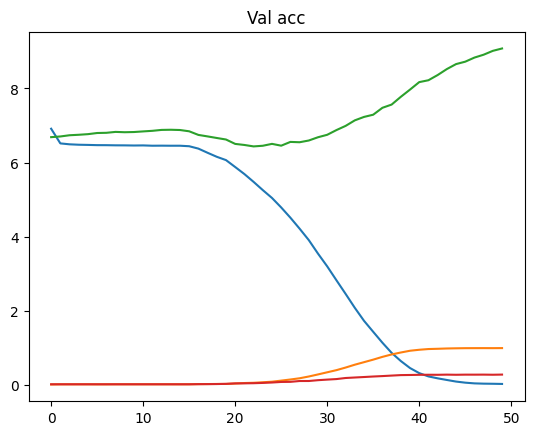

In [8]:
train()